# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

### А ещё есть консультация 2023 года :)

https://www.youtube.com/watch?v=oCwEmKW3bYg

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом. На Windows, скорее всего, вас ждет немало проблем :(

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

Отдельная благодарность А. Абрамову за написание assert для проверки функций и В. Гилязову за поясняющую картинку.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [29]:
# Harry Potter -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip

--2024-11-25 19:47:35--  https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip [following]
--2024-11-25 19:47:36--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38392108 (37M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]  36.61M  --.-KB/s    in 0.1s    

2024-11-25 19:47:36 (270 MB/s) - ‘data.zip.1’ saved [38392108/38392108]



In [30]:
#!sudo apt-get install -y p7zip-full

In [31]:
!mkdir -p data
!7z x data.zip -y -o./


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 38392108 bytes (37 MiB)

Extracting archive: data.zip
--
Path = data.zip
Type = zip
Physical Size = 38392108

  0%     18% 79 - data/images/cam_image4.jpg                                     35% 133 - data/images/cam_image11.jpg                                       51% 190 - data/images/IMG_2497.JPG                                    62% 228 - data/images/cam_image18.jpg                                       75% 269 - 

# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [32]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [33]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):

        x_min = int(member.find("bndbox")[0].text)
        y_min = int(member.find("bndbox")[1].text)
        x_max = int(member.find("bndbox")[2].text)
        y_max = int(member.find("bndbox")[3].text)
        class_id = class_dict[member.find("name").text]

        bboxes.append(
            (x_min,y_min,x_max,y_max,class_id)
        )

    return bboxes

In [34]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        # Нужно обладая файлнеймом подгрузить картинку и бибоксы, функцию для подгрузки бибоксов вы дописали выше :)
        fname = self.filenames[idx]
        image = np.array(Image.open(fname))
        bboxes = get_xml_data(fname, self.root, self.class_dict, xml_prefix="/xmls/")

        # transform будут объявлены ниже за вас
        # Но библиотека привередлива к формату данных на входе, внимательно прочтите прошлую клеточку
        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
       return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [35]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    # Вот тут мы говорим что хотим pascal_voc
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [36]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [37]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break

        channels = list()

        for channel_id in range(images[i].shape[0]):
            channels.append(
                images[i][channel_id] * std[channel_id] + mean[channel_id] # inversed transform
            )

        ax.imshow(torch.stack(channels).permute(1, 2, 0))

        for bbox in bboxes[i]:
            square = plt.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0], # witdh
                bbox[3] - bbox[1], # height
                edgecolor='red',
                fill=False
            )
            ax.add_patch(square)

            ax.text(x=bbox[0],
                    y=bbox[1]-10,
                    s=train_ds.class_dict_inv[bbox[4]],
                    color='red',
                    #backgroundcolor='white',
                    fontsize=8
            )

    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://i.imgur.com/V5TUT26.png)

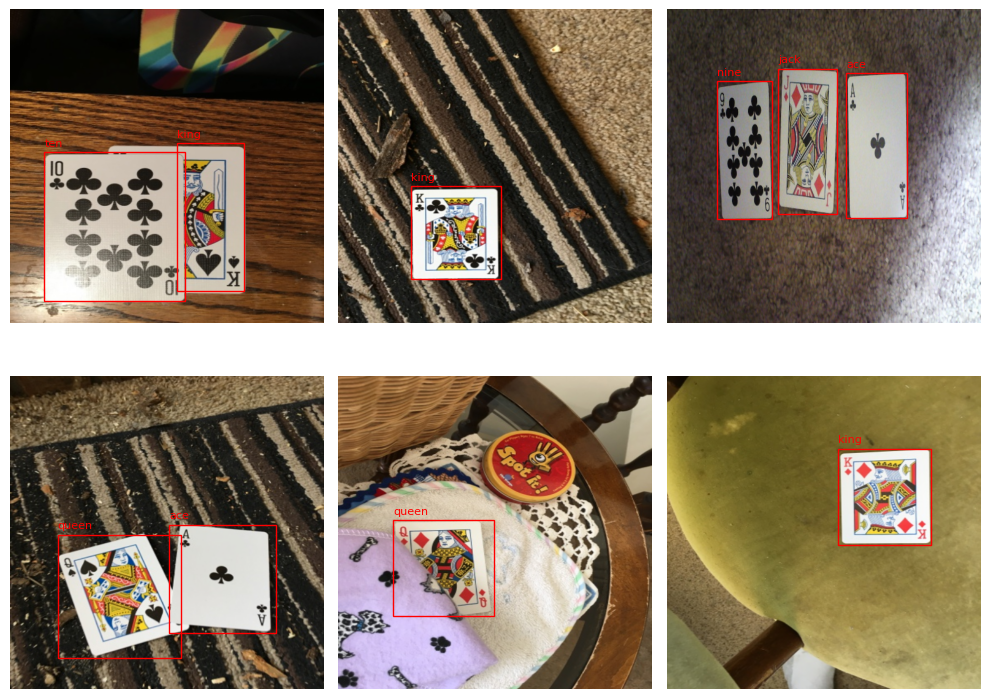

In [38]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и вернуть тензор размера Bx6x16x16. Первая размерность - это количество примеров в батче. Вторая -- "каналы", суть которых написана чуть ниже. Далее идут две пространственные размерности, это сетка 16 на 16. Зафиксируем порядок координат как (y, x) для этой сетки 16 на 16. Это значит, что в target идут ```cy_idx, cx_idx``` в таком порядке, см. код.

В шести "каналах" у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "гиперпиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

### Пояснительная картинка.

Она обладает некоторым уровнем абстракции, чёрных например должно быть 512, а зелёная должна захватывать 32 маленькие черные. Но может будет понятнее :)

![image](https://i.imgur.com/13YVxAd.jpeg)

In [39]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        # Как будто можно было просто сделать x_cell = downsample
        x_cell =  w / (w // downsample)
        y_cell =  h / (h // downsample)


        # ширина и высота бибокса могут превышать размеры гиперпикселя
        # поэтому их мы нормируем на полноценные 512
        # Тут можно заменить w и h на 512. Будет то же самое
        w_box = (xmax-xmin) / w
        h_box = (ymax-ymin) / h

        # Посчитайте координаты центра и сдвиги
        cx =  (xmin+xmax) / 2
        cy =  (ymin+ymax) / 2
        cx_idx =  (cx // x_cell).long()
        cy_idx =  (cy // y_cell).long()

        cx_box =  (cx - (cx_idx * x_cell)) / x_cell
        cy_box =  (cy - (cy_idx * y_cell)) / y_cell

        # cy_idx, потом cx_idx
        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Следующей функцией Вы можете проверить свою реализацию. Проверка не является блокирующей.

In [40]:
def test_collate_fn() -> None:
    target1 = [ 100, 200, 200, 300, 2 ] # xmin, ymin, xmax, ymax, class
    target2_1 = [ 0, 250, 200, 300, 0 ] # xmin, ymin, xmax, ymax, class
    target2_2 = [ 0, 100, 100, 300, 1 ] # xmin, ymin, xmax, ymax, class

    result = collate_fn([
        { 'image': torch.rand((3, 512, 512)), 'bboxes': [ target1 ] },
        { 'image': torch.rand((3, 512, 512)), 'bboxes': [ target2_1, target2_2 ] }
    ])

    # Проверяем размерности
    assert result['image'].shape == (2, 3, 512, 512)
    assert result['target'].shape == (2, 6, 16, 16)

    # Проверяем значения клеточек, в которые попали ббоксы
    assert np.allclose(result['target'][0, :, 7, 4], torch.tensor([ 22 / 32, 26 / 32, 100 / 512, 100 / 512, 1, 2 ]))
    assert np.allclose(result['target'][1, :, 8, 3], torch.tensor([ 4 / 32, 19 / 32, 200 / 512, 50 / 512, 1, 0 ]))
    assert np.allclose(result['target'][1, :, 6, 1], torch.tensor([ 18 / 32, 8 / 32, 100 / 512, 200 / 512, 1, 1 ]))

    # Проверяем, что все остальные клеточки содержат нули
    result['target'][0, :, 7, 4] = result['target'][1, :, 8, 3] = result['target'][1, :, 6, 1] = torch.zeros(6)
    assert np.allclose(result['target'], 0)

test_collate_fn()

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

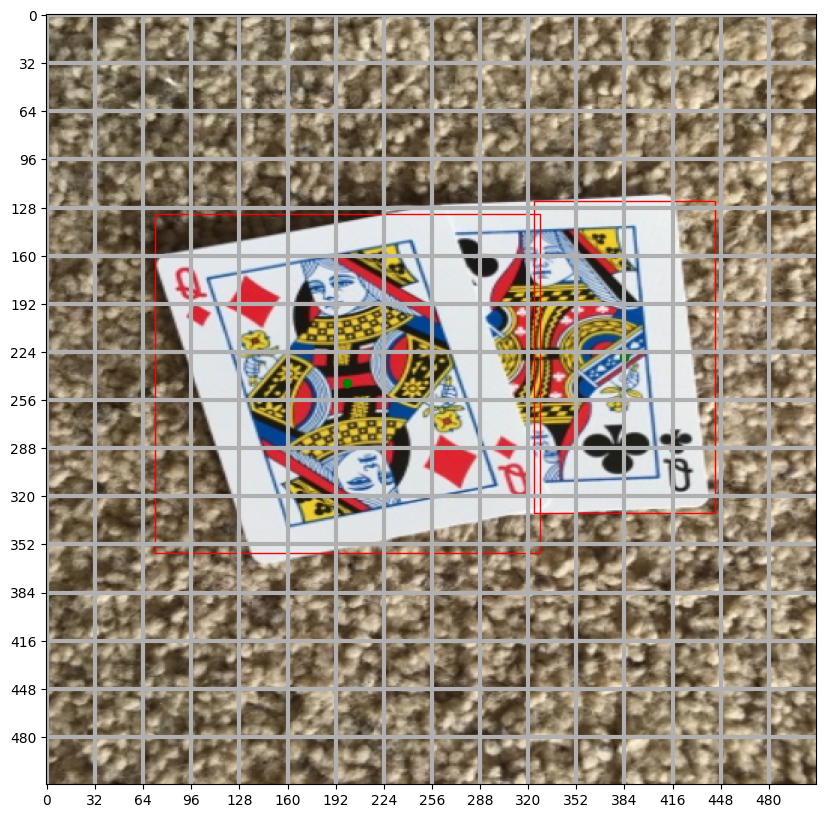

In [41]:
fig, ax = plt.subplots(figsize=(10, 10))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx6x16x16. Почему?

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [42]:
def decode_prediction(pred, upsample=32, threshold=0.7):

    batch_size, channels, heights, widths = pred.shape
    img_width, img_height = widths * upsample, heights * upsample

    x_indices = torch.arange(widths).unsqueeze(0).repeat(heights, 1)
    y_indices = torch.arange(heights).unsqueeze(1).repeat(1, widths)

    decoded_prediction = []

    for i in range(batch_size): # Вроде батчи разрешается перебирать с фором
        batch_pred = pred[i]

        if channels > 6:
            cell_x_box, cell_y_box = batch_pred[0], batch_pred[1]
            box_width, box_height = batch_pred[2], batch_pred[3]
            confidence = batch_pred[4]
            class_scores = batch_pred[5:]
            classes = torch.argmax(class_scores, dim=0)
        else:
            cell_x_box, cell_y_box = batch_pred[0], batch_pred[1]
            box_width, box_height = batch_pred[2], batch_pred[3]
            confidence = batch_pred[4]
            classes = batch_pred[5]

        conf_mask = (confidence > threshold)

        cell_x_box = cell_x_box[conf_mask]
        cell_y_box = cell_y_box[conf_mask]
        box_width = box_width[conf_mask]
        box_height = box_height[conf_mask]
        classes = classes[conf_mask]
        x_idx = x_indices[conf_mask]
        y_idx = y_indices[conf_mask]

        cell_x = (cell_x_box + x_idx) * upsample
        cell_y = (cell_y_box + y_idx) * upsample

        x_dif = img_width * box_width
        y_dif = img_height * box_height

        x_max = (cell_x * 2 + x_dif) // 2
        x_min = 2 * cell_x - x_max

        y_max = (cell_y * 2 + y_dif) // 2
        y_min = 2 * cell_y - y_max

        bounding_boxes = torch.stack(
            [x_min, y_min, x_max, y_max, classes.to(torch.float32)], dim=1
        ).tolist()

        decoded_prediction.append(bounding_boxes)

    return decoded_prediction


Следующей функцией Вы можете проверить свою реализацию. Проверка не является блокирующей.

In [43]:
# Я поменял ассерт, чтобы у него в выводе были вещественные, а не целые числа (без этого изменения он также проходил, оставил прошлую версию после двух #)
def test_decode_predictions() -> None:
    # Применяем collate_fn к некоторым данным
    #target1 = [ [ 100, 200, 200, 300, 2 ] ]
    #target2 = [ [ 0, 250, 200, 300, 0 ], [ 0, 100, 100, 300, 1 ] ]
    target1 = [[100.0, 200.0, 200.0, 300.0, 2.0]]
    target2 = [[0.0, 250.0, 200.0, 300.0, 0.0], [0.0, 100.0, 100.0, 300.0, 1.0]]
    result = collate_fn([
        { 'image': torch.rand((3, 512, 512)), 'bboxes': target1 },
        { 'image': torch.rand((3, 512, 512)), 'bboxes': target2 }
    ])

    target = result['target']
    assert target.shape == (2, 6, 16, 16)
    # В таком виде target соответствует поиску одного класса - 6-ой канал.
    # Добавим еще 2 канала, чтобы проверить работу функции для нескольких классов
    target = torch.cat([ target, torch.zeros(2, 2, 16, 16) ], dim = 1) # Добавляем два канала
    assert target.shape == (2, 8, 16, 16) # Теперь их стало 8

    target[0, 5:, 7, 4] = torch.tensor([ 0.5, 0.6, 0.9 ]) # Это должен быть класс 2
    target[1, 5:, 8, 3] = torch.tensor([ 0.9, 0.6, 0.5 ]) # Это должен быть класс 0
    target[1, 5:, 6, 1] = torch.tensor([ 0.6, 0.9, 0.5 ]) # Это должен быть класс 1

    # Считаем результат
    actual = decode_prediction(target)
    print('Actual:  ', actual)

    # Порядок ббоксов для target2 может меняться в зависимости от вашей реализации и это не ошибка.
    # Скорее всего, он будет такой. Но если ассерт не проходит, попробуйте поменять их местами.
    expected = [ target1, [ target2[1], target2[0] ] ]
    #expected = [ target1, [ target2[0], target2[1] ] ] # <-- такой ответ тоже правильный.
    print('Expected:', expected)

    # Сравниваем
    assert actual == expected

test_decode_predictions()

Actual:   [[[100.0, 200.0, 200.0, 300.0, 2.0]], [[0.0, 100.0, 100.0, 300.0, 1.0], [0.0, 250.0, 200.0, 300.0, 0.0]]]
Expected: [[[100.0, 200.0, 200.0, 300.0, 2.0]], [[0.0, 100.0, 100.0, 300.0, 1.0], [0.0, 250.0, 200.0, 300.0, 0.0]]]


## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [44]:
!pip install pytorch-lightning

In [45]:
import pytorch_lightning as pl

In [46]:
# По примеру из 6-го семинара вынесу ChannelReduction в отдельный блок

C =  6

class ChannelReduction(pl.LightningModule):
    def __init__(self, in_channels_size: int, out_channels_size: int):
        super().__init__()
        # Буду использовать то, что написано в задании
        self.channel_reduction_block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels_size, out_channels=out_channels_size, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels_size),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.channel_reduction_block(x)


class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)

        self.resnet_conv = model.conv1
        self.resnet_bn = model.bn1
        self.resnet_relu = model.relu
        self.resnet_maxpool = model.maxpool
        self.resnet_layer1 = model.layer1
        self.resnet_layer2 = model.layer2
        self.resnet_layer3 = model.layer3
        self.resnet_layer4 = model.layer4


        self.reduction2048 = ChannelReduction(2048, 512)
        self.reduction512 = ChannelReduction(512, 128)
        self.reduction128 = ChannelReduction(128, 32)
        self.reduction32 = ChannelReduction(32, 5+C)

        self.sigmoid = nn.Sigmoid()



    def forward(self, x):
        # ResNet50
        with torch.no_grad():
            x = self.resnet_conv(x)
            x = self.resnet_bn(x)
            x = self.resnet_relu(x)
            x = self.resnet_maxpool(x)
            x = self.resnet_layer1(x)
            x = self.resnet_layer2(x)
            x = self.resnet_layer3(x)
            x = self.resnet_layer4(x)

        x = self.reduction2048(x)
        x = self.reduction512(x)
        x = self.reduction128(x)
        x = self.reduction32(x)

        return self.sigmoid(x)

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. Подумайте как зависит индексация от параметра C и используйте его.

In [93]:
def special_loss(prediction, target, check=False):
    mse_loss = nn.MSELoss(reduction='sum')
    cross_entropy_loss = nn.CrossEntropyLoss(reduction='sum')
    bce_loss = nn.BCELoss(reduction='sum')

    mask = (target[:, 4, :, :] == 1)

    localization_loss = mse_loss(
        prediction[:, 0:2, :, :][mask.unsqueeze(1).expand_as(prediction[:, 0:2, :, :])],
        target[:, 0:2, :, :][mask.unsqueeze(1).expand_as(target[:, 0:2, :, :])]
    )

    box_loss = mse_loss(
        prediction[:, 2:4, :, :][mask.unsqueeze(1).expand_as(prediction[:, 2:4, :, :])],
        target[:, 2:4, :, :][mask.unsqueeze(1).expand_as(target[:, 2:4, :, :])]
    )

    classification_loss = cross_entropy_loss(
        prediction[:, 5:, :, :].permute(0, 2, 3, 1)[mask].view(-1, prediction.size(1) - 5),
        target[:, 5, :, :][mask].view(-1).long()

    )

    confidence_loss_object = bce_loss(
        prediction[:, 4, :, :][mask],
        target[:, 4, :, :][mask]
    )

    confidence_loss_no_object = bce_loss(
        prediction[:, 4, :, :][~mask],
        target[:, 4, :, :][~mask]
    )
    confidence_loss = confidence_loss_object + 0.1 * confidence_loss_no_object


    if check:
        return localization_loss, box_loss, classification_loss, confidence_loss
    return localization_loss + box_loss + classification_loss + confidence_loss

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [94]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [95]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [96]:
torch.manual_seed(21)
EPOCHS =  15
model = Detector().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [97]:
# Видимо нельзя использовать лайтнинг,
# но уже не буду убирать импорт, так как использовал его в блоке
for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        x = batch["image"].to(device)
        target = batch["target"].to(device)#.squeeze()

        # pred
        y_pred = model(x).to(device)#.squeeze()
        loss = special_loss(y_pred, target)
        epoch_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 0 done; Train loss 240.232;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1 done; Train loss 220.776;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2 done; Train loss 212.815;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3 done; Train loss 208.072;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4 done; Train loss 206.135;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5 done; Train loss 205.193;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6 done; Train loss 204.646;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7 done; Train loss 204.219;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8 done; Train loss 203.757;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9 done; Train loss 203.626;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10 done; Train loss 203.421;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11 done; Train loss 203.132;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12 done; Train loss 203.014;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13 done; Train loss 202.993;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14 done; Train loss 202.910;


Запустим обученный детектор на тестовых изображениях:

In [98]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [99]:
# Нужно сделать предсказание и переложить результат на cpu

y_preds = []
for batch in tqdm(test_loader):
    x = batch["image"].to(device)
    target = batch["target"].to(device)#.squeeze()

    y_pred = model(x).to("cpu")#.squeeze()

    y_preds.append(y_pred)

  0%|          | 0/7 [00:00<?, ?it/s]

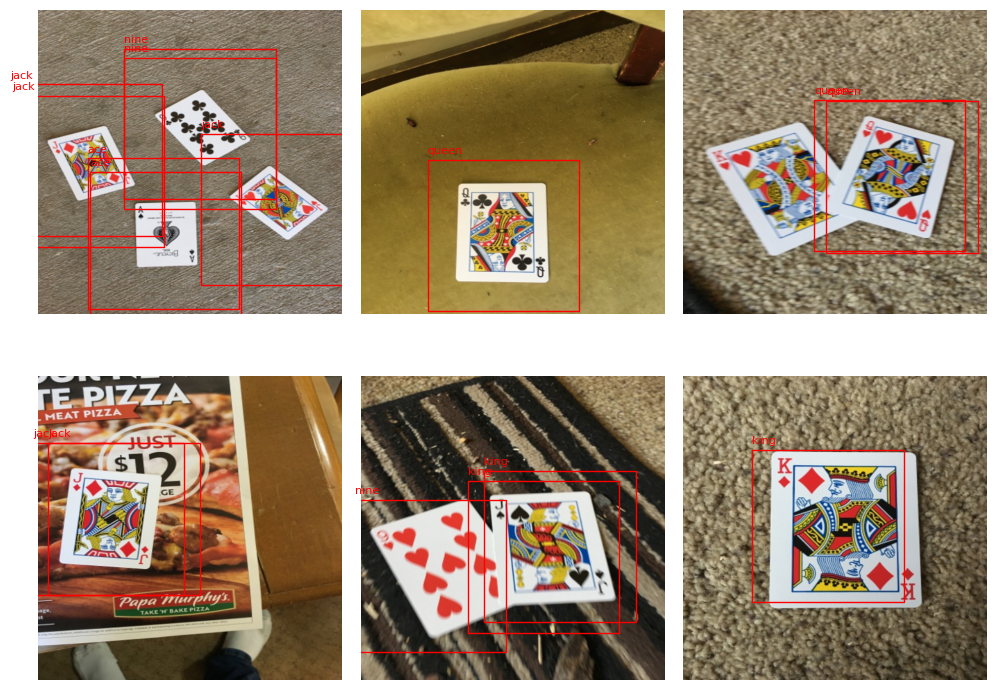

In [100]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1
# При 0.1 карты детектируются в каждом гиперпикселе. Оставил порог 0.75.
# При таком пороге объекты иногда детектируются по несколько раз,
# но при этом, на удивление, все объекты из 6 картинок теста детектируются правильно
# Проблему повторного детектирования должен решить NMS, но вроде его добавлять не надо

n = 6

test_loader = [test_ds[i] for i in range(n)]

images = [item["image"] for item in test_loader]
decoded_predictions = decode_prediction(y_preds[0], threshold=0.75)

visualize(images, decoded_predictions)

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO 11 от ultralytics.

In [ ]:
!pip install ultralytics==8.3.34 # В чате писали, что последняя версия сломана

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 kB 44.7 MB/s eta 0:00:00
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.3.36
    Uninstalling ultralytics-8.3.36:
      Successfully uninstalled ultralytics-8.3.36


## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [ ]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO 11. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

Использовать сторонние инструменты нельзя, нужно переложить своими руками.

In [ ]:
def annotation2txt(bboxes, w_im, h_im):
    strings = []

    for bbox in bboxes:
        x_min = bbox[0]
        y_min = bbox[1]
        x_max = bbox[2]
        y_max = bbox[3]
        class_id = bbox[4]

        cx = (x_max + x_min) / 2 / w_im
        cy = (y_max + y_min) / 2 / h_im
        w = (x_max - x_min) / w_im
        h = (y_max - y_min) / h_im


        strings.append(f'{class_id} {cx} {cy} {w} {h}')

    return strings

In [ ]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [ ]:
# Собираем YAML

nc =  6
names =  ["king", "jack", "ace", "ten", "nine", "queen"]

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO 11 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель можно взять обученную.

Подсказка: подумайте зачем вам data.yaml и что такое yolo11n.yaml (не стесняйтесь гуглить)

Если у вас лосс NaN или Windows, то есть несколько полезных ссылок (покрывают не все существующие проблемы, но может поможет вам):

https://github.com/ultralytics/ultralytics/issues/1149

https://github.com/ultralytics/yolov5/issues/6907

https://stackoverflow.com/questions/75178762/i-got-nan-for-all-losses-while-training-yolov8-model

In [ ]:
import ultralytics

model = ultralytics.YOLO('yolo11n.yaml')

results = model.train(data="data.yaml", epochs=100)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
New https://pypi.org/project/ultralytics/8.3.36 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.yaml, data=data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0

100%|██████████| 755k/755k [00:00<00:00, 87.8MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 316MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<00:00, 1693.94it/s]


train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/valid/labels... 37 images, 0 backgrounds, 0 corrupt: 100%|██████████| 37/37 [00:00<00:00, 1173.60it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.93G      2.993      4.611      4.365         27        640: 100%|██████████| 21/21 [00:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all         37         65   5.69e-05     0.0111   3.18e-05   3.18e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.86G      3.008      4.443      4.098         20        640: 100%|██████████| 21/21 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]

                   all         37         65   6.52e-05     0.0111   4.18e-05   4.18e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.86G      2.869      4.213      3.827         19        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

                   all         37         65   6.14e-05     0.0111   4.87e-05   9.73e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.87G      2.896      3.931      3.648         22        640: 100%|██████████| 21/21 [00:10<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         37         65   7.97e-05     0.0111   5.74e-05   5.74e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.86G      2.882       3.91      3.486         14        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.93it/s]

                   all         37         65   0.000285     0.0333    0.00492   0.000742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.86G      2.765      3.679      3.312         24        640: 100%|██████████| 21/21 [00:08<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         37         65   0.000408     0.0963    0.00475    0.00188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.87G       2.67      3.541      3.213         21        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

                   all         37         65      0.288     0.0333     0.0248    0.00769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.86G      2.584      3.432      3.126         26        640: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         37         65      0.365     0.0128    0.00451   0.000835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.86G      2.436      3.192      2.975         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         37         65   0.000944      0.146    0.00128   0.000395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.88G      2.322      3.125      2.896         32        640: 100%|██████████| 21/21 [00:08<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         37         65     0.0193     0.0111    0.00352     0.0018



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.86G      2.172       2.94      2.779         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]

                   all         37         65      0.375     0.0564     0.0372     0.0241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.86G      2.054      2.821      2.655         23        640: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         37         65      0.476     0.0444     0.0495     0.0171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.86G      1.962       2.74      2.583         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]

                   all         37         65       0.14     0.0573     0.0459     0.0322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.86G      1.807      2.573      2.409         19        640: 100%|██████████| 21/21 [00:06<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         37         65      0.171     0.0805     0.0496     0.0397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.86G      1.757      2.526      2.376         25        640: 100%|██████████| 21/21 [00:06<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]


                   all         37         65      0.768     0.0519     0.0339     0.0257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.86G      1.648      2.396      2.246         24        640: 100%|██████████| 21/21 [00:06<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

                   all         37         65     0.0927     0.0573     0.0384     0.0278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.88G      1.592      2.341      2.186         23        640: 100%|██████████| 21/21 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         37         65      0.104     0.0775     0.0483     0.0394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.86G       1.54      2.273      2.115         32        640: 100%|██████████| 21/21 [00:07<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         37         65      0.157     0.0812     0.0385     0.0286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.86G      1.518      2.217      2.057         24        640: 100%|██████████| 21/21 [00:07<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

                   all         37         65       0.11     0.0997     0.0425     0.0279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.86G      1.464      2.174      2.008         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]


                   all         37         65     0.0934     0.0812     0.0396     0.0295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.88G      1.453      2.127      2.005         28        640: 100%|██████████| 21/21 [00:07<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.30it/s]

                   all         37         65      0.122     0.0812     0.0534     0.0397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.86G      1.375      2.093      1.932         41        640: 100%|██████████| 21/21 [00:05<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         37         65      0.123     0.0997     0.0563     0.0445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.86G      1.359      2.096       1.89         15        640: 100%|██████████| 21/21 [00:08<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         37         65     0.0821     0.0886     0.0337     0.0259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.86G      1.349      2.028      1.864         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         37         65      0.117     0.0997     0.0404     0.0322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.86G      1.294      2.055       1.86         26        640: 100%|██████████| 21/21 [00:09<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

                   all         37         65      0.187     0.0997     0.0714     0.0607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.86G      1.278      1.971      1.813         25        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         37         65     0.0828      0.111     0.0304     0.0259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.86G      1.236      1.907      1.773         32        640: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         37         65     0.0865     0.0912     0.0455     0.0406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.84G       1.19      1.843      1.717         25        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]

                   all         37         65      0.116     0.0997     0.0448      0.039



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.86G      1.195      1.833      1.717         32        640: 100%|██████████| 21/21 [00:08<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         37         65     0.0896     0.0997     0.0555     0.0485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.86G      1.146      1.791       1.66         24        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]

                   all         37         65      0.347     0.0869     0.0693     0.0618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.86G      1.122      1.729      1.649         26        640: 100%|██████████| 21/21 [00:06<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         37         65       0.33     0.0783     0.0746     0.0678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.86G      1.137      1.739      1.644         31        640: 100%|██████████| 21/21 [00:07<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.89it/s]

                   all         37         65     0.0877     0.0997     0.0518     0.0483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.84G      1.074      1.724      1.617         24        640: 100%|██████████| 21/21 [00:06<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         37         65     0.0662      0.111     0.0339     0.0303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.88G      1.082      1.681      1.599         25        640: 100%|██████████| 21/21 [00:06<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]

                   all         37         65      0.094      0.109     0.0476     0.0402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.86G      1.062      1.658      1.587         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         37         65      0.118      0.111      0.068     0.0581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.86G      1.079      1.673      1.595         17        640: 100%|██████████| 21/21 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.25it/s]

                   all         37         65       0.11      0.098      0.067     0.0606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.84G      1.101      1.645      1.603         28        640: 100%|██████████| 21/21 [00:06<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         37         65     0.0766      0.111     0.0337     0.0302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.86G      1.079      1.626      1.599         19        640: 100%|██████████| 21/21 [00:09<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         37         65     0.0688     0.0923     0.0461     0.0414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.88G      1.041        1.6       1.55         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         37         65      0.554     0.0795     0.0585     0.0508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.86G      1.003      1.563      1.532         26        640: 100%|██████████| 21/21 [00:08<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


                   all         37         65      0.462     0.0684     0.0405     0.0349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.84G      1.016      1.584      1.537         21        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]

                   all         37         65      0.129      0.098     0.0392     0.0315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.88G      1.001      1.536      1.502         25        640: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all         37         65     0.0931      0.111     0.0603     0.0561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.86G     0.9432      1.499      1.469         36        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         37         65      0.128     0.0923     0.0476      0.041



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.86G     0.9717      1.509      1.485         27        640: 100%|██████████| 21/21 [00:06<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         37         65     0.0913     0.0997     0.0378      0.032



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.88G     0.9694      1.489      1.486         18        640: 100%|██████████| 21/21 [00:06<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.39it/s]

                   all         37         65       0.13      0.108     0.0693     0.0614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.86G     0.9526      1.478      1.468         26        640: 100%|██████████| 21/21 [00:06<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

                   all         37         65      0.158      0.111     0.0591     0.0521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.86G     0.9108      1.438       1.44         16        640: 100%|██████████| 21/21 [00:07<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

                   all         37         65      0.558     0.0923     0.0695     0.0623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.86G      0.985      1.454      1.494         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         37         65      0.461     0.0923     0.0587     0.0544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.86G     0.9258      1.426      1.439         34        640: 100%|██████████| 21/21 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         37         65     0.0854      0.111     0.0326     0.0289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.88G     0.9272      1.455      1.453         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

                   all         37         65      0.108      0.111      0.044      0.039



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.88G     0.9112      1.389      1.433         27        640: 100%|██████████| 21/21 [00:08<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

                   all         37         65      0.336     0.0909      0.057     0.0503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.86G     0.9147       1.37      1.442         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

                   all         37         65      0.546     0.0923     0.0645     0.0573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.86G      0.929      1.397      1.439         21        640: 100%|██████████| 21/21 [00:08<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         37         65     0.0919      0.111     0.0505     0.0447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.87G     0.9345      1.415      1.457         18        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         37         65      0.136      0.111     0.0618     0.0563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.86G     0.8974      1.325      1.416         36        640: 100%|██████████| 21/21 [00:07<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         37         65      0.124      0.111     0.0538     0.0487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.86G     0.9083      1.348      1.429         27        640: 100%|██████████| 21/21 [00:07<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

                   all         37         65      0.474     0.0923     0.0622     0.0551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.88G     0.8744      1.328      1.393         25        640: 100%|██████████| 21/21 [00:08<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         37         65        0.5     0.0923     0.0665     0.0604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.86G     0.8686      1.286       1.39         25        640: 100%|██████████| 21/21 [00:05<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

                   all         37         65      0.135      0.111     0.0623     0.0597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.86G     0.8751        1.3      1.381         26        640: 100%|██████████| 21/21 [00:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         37         65      0.486     0.0923     0.0526     0.0411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.86G     0.8593       1.27      1.373         39        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

                   all         37         65      0.136      0.111     0.0508     0.0444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.86G     0.8492      1.297      1.361         23        640: 100%|██████████| 21/21 [00:06<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         37         65      0.478     0.0923      0.043     0.0391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.86G     0.8686      1.282      1.379         30        640: 100%|██████████| 21/21 [00:06<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.42it/s]

                   all         37         65      0.117      0.111     0.0618     0.0569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.88G     0.8651      1.263      1.369         19        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all         37         65      0.172      0.111     0.0496     0.0448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.84G      0.843      1.265      1.352         27        640: 100%|██████████| 21/21 [00:07<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

                   all         37         65      0.141     0.0923     0.0537     0.0494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.88G      0.845      1.251      1.362         25        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

                   all         37         65      0.122      0.111     0.0433      0.039



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.86G     0.8423      1.285      1.364         17        640: 100%|██████████| 21/21 [00:08<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.28it/s]

                   all         37         65      0.133      0.111     0.0434      0.038



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.86G     0.8055      1.217      1.331         23        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

                   all         37         65      0.477     0.0923     0.0387     0.0368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.84G     0.8173       1.23      1.357         22        640: 100%|██████████| 21/21 [00:08<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         37         65      0.332      0.098     0.0557     0.0505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.86G     0.8236      1.217      1.354         23        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]

                   all         37         65       0.49     0.0923     0.0609     0.0562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.86G     0.8255      1.218      1.355         33        640: 100%|██████████| 21/21 [00:07<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         37         65      0.121      0.111     0.0458     0.0411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.88G     0.8377      1.242      1.348         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.32it/s]

                   all         37         65      0.325      0.111     0.0426      0.039



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.86G     0.7736      1.176      1.297         24        640: 100%|██████████| 21/21 [00:06<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         37         65      0.495      0.092     0.0499     0.0469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.86G     0.7701      1.183      1.317         21        640: 100%|██████████| 21/21 [00:06<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

                   all         37         65      0.333     0.0923     0.0488     0.0439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.88G     0.7778      1.145      1.301         13        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         37         65      0.303      0.111     0.0623      0.058



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.86G     0.7422      1.142       1.28         21        640: 100%|██████████| 21/21 [00:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all         37         65      0.115      0.111     0.0448     0.0429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.86G     0.7646      1.123      1.288         30        640: 100%|██████████| 21/21 [00:09<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         37         65      0.142       0.11     0.0616     0.0552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.88G     0.7613       1.13       1.29         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         37         65      0.477     0.0923     0.0439     0.0395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.88G     0.7985      1.172      1.335         33        640: 100%|██████████| 21/21 [00:06<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         37         65      0.319       0.11     0.0409     0.0378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.84G      0.764      1.128      1.313         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

                   all         37         65      0.305      0.109     0.0367     0.0333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.86G     0.7714       1.14      1.296         20        640: 100%|██████████| 21/21 [00:06<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         37         65       0.13      0.111     0.0495     0.0469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.88G     0.7473      1.101      1.292         31        640: 100%|██████████| 21/21 [00:06<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         37         65      0.314     0.0923     0.0403     0.0382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.86G      0.756      1.121      1.292         24        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         37         65      0.502     0.0923     0.0646      0.059



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.86G     0.7358      1.083      1.277         17        640: 100%|██████████| 21/21 [00:07<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         37         65      0.322     0.0923     0.0547     0.0514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.87G      0.781      1.161      1.334         14        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

                   all         37         65      0.319      0.111     0.0426     0.0411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.88G     0.7558      1.111       1.29         28        640: 100%|██████████| 21/21 [00:08<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

                   all         37         65      0.119      0.111     0.0441     0.0414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.87G      0.731       1.07       1.27         18        640: 100%|██████████| 21/21 [00:05<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         37         65      0.315     0.0923      0.046      0.042



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.88G     0.7537      1.067       1.28         30        640: 100%|██████████| 21/21 [00:08<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.96it/s]

                   all         37         65      0.329     0.0812     0.0459     0.0415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.86G     0.7562      1.098      1.292         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         37         65      0.343      0.111     0.0458      0.043



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.86G     0.7104      1.053      1.252         22        640: 100%|██████████| 21/21 [00:13<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

                   all         37         65      0.347      0.111     0.0439     0.0405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.89G     0.7065      1.027      1.246         18        640: 100%|██████████| 21/21 [00:07<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         37         65      0.312      0.111     0.0476     0.0458


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.02G      0.592      1.005      1.148         16        640: 100%|██████████| 21/21 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

                   all         37         65      0.298     0.0923     0.0411     0.0401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.84G      0.564     0.9438      1.123         13        640: 100%|██████████| 21/21 [00:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         37         65      0.132      0.111     0.0384     0.0349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.84G     0.5816     0.9139      1.134         13        640: 100%|██████████| 21/21 [00:12<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         37         65      0.147      0.111     0.0354     0.0327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.84G     0.5312     0.8465      1.081         11        640: 100%|██████████| 21/21 [00:06<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]

                   all         37         65      0.125      0.111     0.0331     0.0306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.84G     0.5515     0.8283      1.107          8        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         37         65      0.137      0.111     0.0359     0.0329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.84G     0.5426     0.8471      1.092         12        640: 100%|██████████| 21/21 [00:07<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

                   all         37         65      0.137      0.111      0.037     0.0337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.84G      0.533     0.8076      1.076         16        640: 100%|██████████| 21/21 [00:05<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         37         65      0.127      0.111     0.0369     0.0343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.84G     0.5358     0.8075      1.088         11        640: 100%|██████████| 21/21 [00:07<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

                   all         37         65      0.117      0.111     0.0348     0.0323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.85G     0.5416     0.8032      1.104         15        640: 100%|██████████| 21/21 [00:05<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         37         65      0.127      0.111     0.0394     0.0361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.84G     0.5134     0.7696      1.077         10        640: 100%|██████████| 21/21 [00:09<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

                   all         37         65      0.145      0.111     0.0441     0.0417



100 epochs completed in 0.244 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]


                   all         37         65      0.328     0.0784     0.0744     0.0676
                  king         13         13       0.63      0.137       0.13      0.117
                  jack          9          9          1          0     0.0112     0.0101
                   ace         14         15      0.239        0.2      0.166      0.155
                   ten          7          8          0          0          0          0
                  nine         13         15     0.0981      0.133      0.137      0.123
                 queen          5          5          0          0    0.00287   0.000574
Speed: 0.2ms preprocess, 3.5ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [ ]:
results = model(test_ds.filenames[0:36:6], conf=0.16) # Тут уже возьму порог ближе к 0.1 (но при 0.1 много лишних детекций)


0: 640x480 (no detections), 4.1ms
1: 640x480 1 jack, 1 queen, 4.1ms
2: 640x480 1 ace, 3 tens, 3 nines, 4.1ms
3: 640x480 1 king, 3 jacks, 1 nine, 3 queens, 4.1ms
4: 640x480 1 ace, 1 nine, 4.1ms
5: 640x480 1 jack, 4.1ms
Speed: 2.7ms preprocess, 4.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


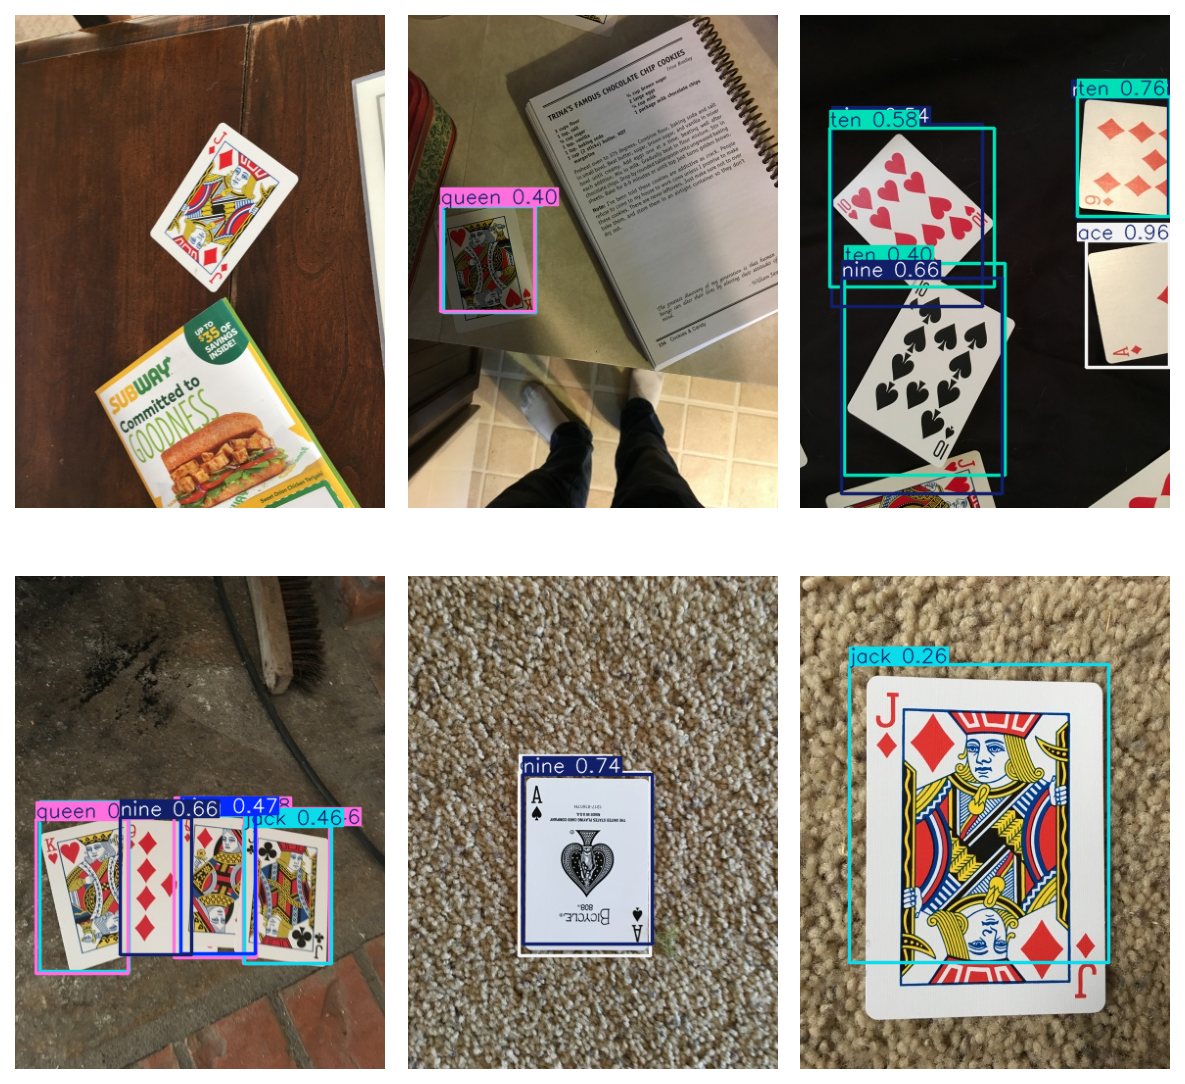

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(8, 8), dpi=150)

for i, result in enumerate(results):
    im_array = result.plot()
    im_rgb = im_array[..., ::-1]

    axes[i // 3, i % 3].imshow(im_rgb)
    axes[i // 3, i % 3].axis('off')

    #axes[i // 3, i % 3].set_title(f'Image {i + 1}')


plt.tight_layout()
plt.show()

# Модель не особо уверенная в многих ответах, часто не детектит очевидные объекты или детектит объекты неправильного класса
# Скорее всего не охватило аугментаций и размера датасета
# На 5 изображении туз задетектился, но 9 его перекрывает